In [69]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%config InlineBackend.figure_format = 'retina'


mpl.rc('axes, unicode_minus = False')

In [70]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


## Variable Definition

In [71]:
import easydict
pin = easydict.EasyDict

pin.default_path ="/content/data/MyDrive/playdata/TitanicCompetitionData/"
pin.train_csv = pin.default_path + 'train.csv'
pin.test_csv = pin.default_path + 'test.csv'
pin.default_submission_csv = pin.default_path + 'submission.csv'

pin.save_results = pin.default_path + 'result/model_results.json'

pin.random_state = 0
pin.results = []

## Load Data

In [72]:
ori_train = pd.read_csv(pin.train_csv)
ori_test = pd.read_csv(pin.test_csv)

In [73]:
ori_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name         393 non-null    object 
 3   gender       393 non-null    object 
 4   age          310 non-null    float64
 5   sibsp        393 non-null    int64  
 6   parch        393 non-null    int64  
 7   ticket       393 non-null    object 
 8   fare         392 non-null    float64
 9   cabin        97 non-null     object 
 10  embarked     392 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 33.9+ KB


In [74]:
ori_train.shape, ori_train.columns

((916, 12),
 Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
        'parch', 'ticket', 'fare', 'cabin', 'embarked'],
       dtype='object'))

In [75]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [76]:
ori_train.describe(include = np.number)

,passengerid,survived,pclass,age,sibsp,parch,fare
count,916.000000,916.000000,916.000000,736.000000,916.000000,916.000000,916.000000
mean,457.500000,0.377729,2.292576,29.698370,0.507642,0.361354,32.402710
std,264.570721,0.485084,0.838675,14.185627,1.044866,0.828054,50.506411
min,0.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,228.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,457.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.458300
75%,686.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.017700
max,915.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


# Features

In [77]:
# 결측치 확인
ori_train.isna().sum(), ori_test.isna().sum()

# age의 결측치 비율이 가장 높음

(passengerid      0
 survived         0
 pclass           0
 name             0
 gender           0
 age            180
 sibsp            0
 parch            0
 ticket           0
 fare             0
 cabin          718
 embarked         1
 dtype: int64,
 passengerid      0
 pclass           0
 name             0
 gender           0
 age             83
 sibsp            0
 parch            0
 ticket           0
 fare             1
 cabin          296
 embarked         1
 dtype: int64)

## Age

In [221]:
# age 결측치 처리를 위한 dataframe
df_for_age = ori_train.copy()

In [222]:
# title in name
title = list(set(df_for_age.name.str.split().str[1]))
title = [i for i in title if '.' in i]
title += ['Countess', 'Sir', 'Don.']
title

['Ms.',
 'Don.',
 'Jonkheer.',
 'Mr.',
 'Dr.',
 'Mlle.',
 'Capt.',
 'Major.',
 'Mrs.',
 'Master.',
 'Rev.',
 'Col.',
 'Miss.',
 'Countess',
 'Sir',
 'Don.']

In [223]:
# title 추출 함수
def name_to_title(x):
  for i in title:
    if i in x:
      return i

In [224]:
# title value counts
df_for_age["title"] = df_for_age["name"].map(lambda x: name_to_title(x))
df_for_age["title"].value_counts()

Mr.          528
Miss.        185
Mrs.         138
Master.       42
Rev.           6
Dr.            5
Col.           3
Major.         2
Don.           1
Ms.            1
Jonkheer.      1
Mlle.          1
Countess       1
Capt.          1
Sir            1
Name: title, dtype: int64

In [225]:
# title column
ori_train['title'] = ori_train.name.map(lambda x: name_to_title(x))
ori_test['title'] = ori_test.name.map(lambda x: name_to_title(x))

<Axes: xlabel='age', ylabel='title'>

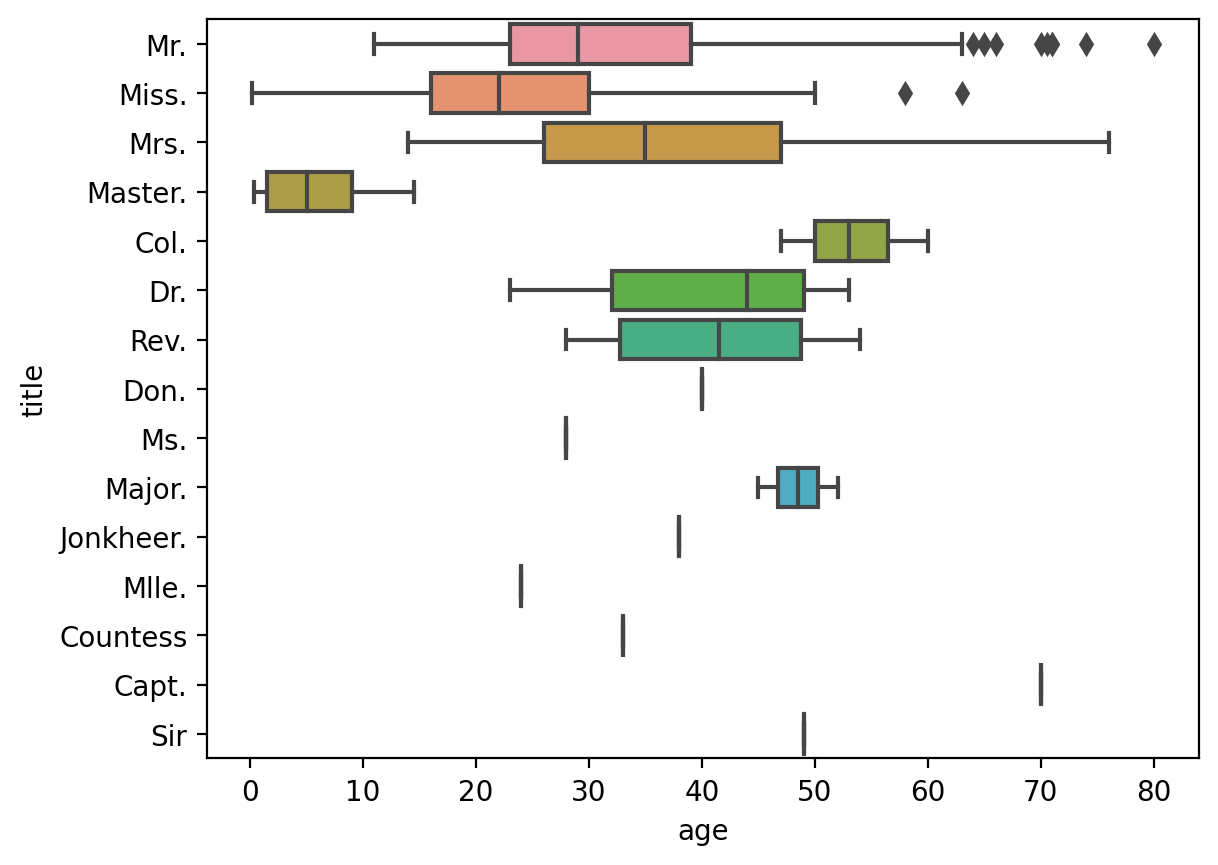

In [226]:
# title 별 age 분포 확인
sns.boxplot(ori_train, x = 'age', y = 'title')

In [227]:
# title 별 age 평균
title_age_mean = df_for_age[['age','title']].groupby(['title']).mean()
title_age_mean.age=round(title_age_mean.age)
title_age_mean.rename(columns = {'age':'age_mean'},inplace = True)
title_age_mean.reset_index(inplace = True)
title_age_mean

,title,age_mean
0,Capt.,70.0
1,Col.,53.0
2,Countess,33.0
3,Don.,40.0
4,Dr.,40.0
5,Jonkheer.,38.0
6,Major.,48.0
7,Master.,5.0
8,Miss.,22.0
9,Mlle.,24.0


In [228]:
df_tr = ori_train.merge(title_age_mean, how= 'left')
df_te = ori_test.merge(title_age_mean, how= 'left')

In [229]:
# age 결측치 처리
df_tr.age.fillna(df_tr.age_mean, inplace = True)
df_te.age.fillna(df_te.age_mean, inplace = True)
df_tr.age.isna().sum()

0

## Pclass

In [230]:
df_tr.pclass = df_tr.pclass.astype('object')
df_te.pclass = df_te.pclass.astype('object')

In [231]:
df_tr.columns, df_te.columns

(Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
        'parch', 'ticket', 'fare', 'cabin', 'embarked', 'title', 'age_mean'],
       dtype='object'),
 Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
        'ticket', 'fare', 'cabin', 'embarked', 'title', 'age_mean'],
       dtype='object'))

## Embarked

In [235]:
df_tr.embarked.isna().sum()

1

In [237]:
df_tr.embarked.fillna(df_tr.embarked.mode()[0],inplace = True)
df_te.embarked.fillna(df_tr.embarked.mode()[0],inplace = True)
df_tr.embarked.isna().sum(), df_te.embarked.isna().sum()

(0, 0)

## Family

In [238]:
#family 생성
df_tr['family'] = df_tr.parch + df_tr.sibsp
df_te['family'] = df_te.parch + df_te.sibsp
df_tr.family.value_counts()

# 4인 이상의 counts 매우 낮음

0     558
1     163
2     109
3      26
4      19
5      19
6       9
10      7
7       6
Name: family, dtype: int64

In [239]:
#family 범주화(4인 이상 통합합)
df_tr.family = df_tr.family.map(lambda x: 4 if x >= 4 else x)
df_te.family = df_te.family.map(lambda x: 4 if x >= 4 else x)

#sibsp, parch drop
df_tr.drop(columns = ['sibsp', 'parch'],inplace = True)
df_te.drop(columns = ['sibsp', 'parch'],inplace = True)

## Gender

In [240]:
# gender
df_tr.gender = df_tr.gender.map(lambda x: 0 if x=='male' else 1)
df_te.gender = df_te.gender.map(lambda x: 0 if x=='male' else 1)

## Fare

In [241]:
df_tr[['family','fare']].groupby('family').mean() 
#동승자 수에 따라 요금 평균이 높아짐

,fare
family,
0,22.109661
1,51.663090
2,36.337690
3,45.922435
4,62.796947


<Axes: xlabel='pclass', ylabel='fare'>

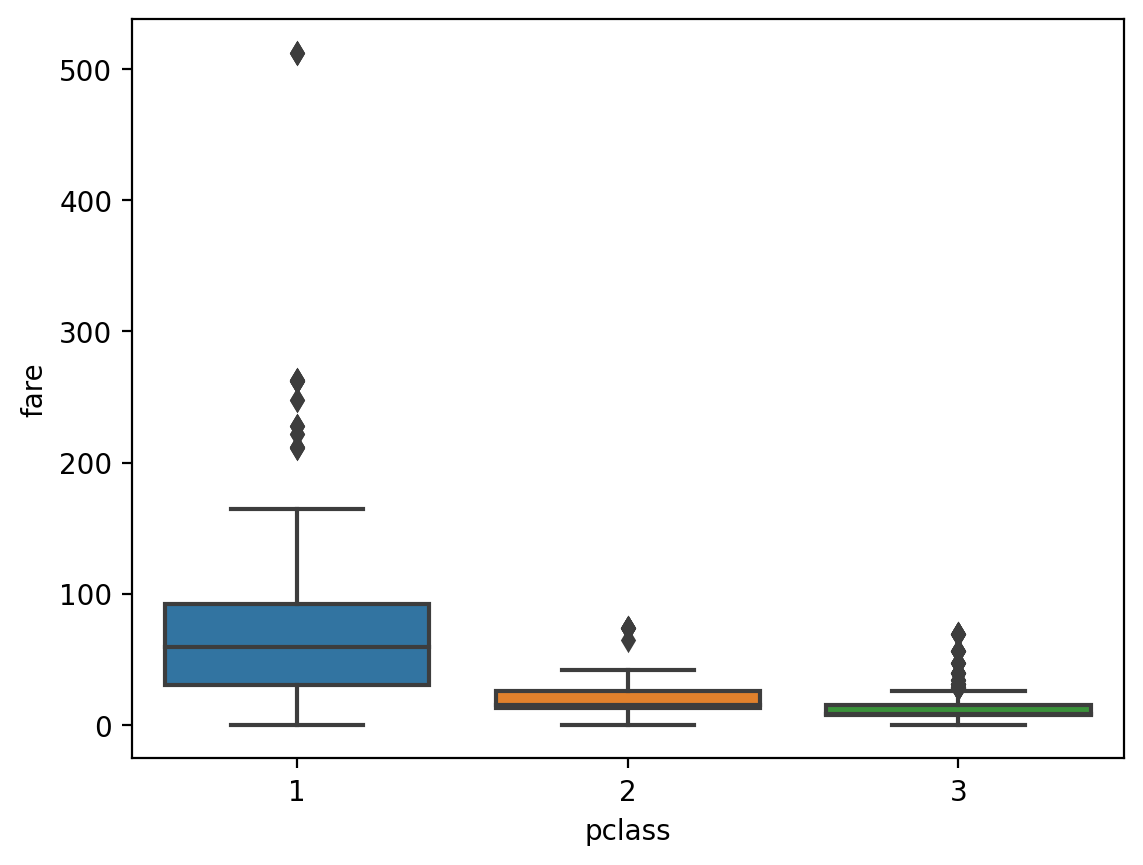

In [242]:
sns.boxplot(df_tr,x = 'pclass', y='fare')

In [243]:
# fare/family
df_tr.rename(columns = {'fare':'ori_fare'},inplace = True)
df_tr['fare']= df_tr.ori_fare / (df_tr.family+1)
df_tr.drop(columns = ['ori_fare'], inplace =True)

df_te.rename(columns = {'fare':'ori_fare'},inplace = True)
df_te['fare']= df_te.ori_fare / (df_te.family+1)
df_te.drop(columns = ['ori_fare'], inplace =True)


#fare결측치 처리(평균)
df_te.fare.fillna(df_tr.fare.mean(), inplace = True)

In [244]:
df_tr[['family','fare']].groupby('family').mean()

,fare
family,
0,22.109661
1,25.831545
2,12.112563
3,11.480609
4,12.559389


<Axes: xlabel='pclass', ylabel='fare'>

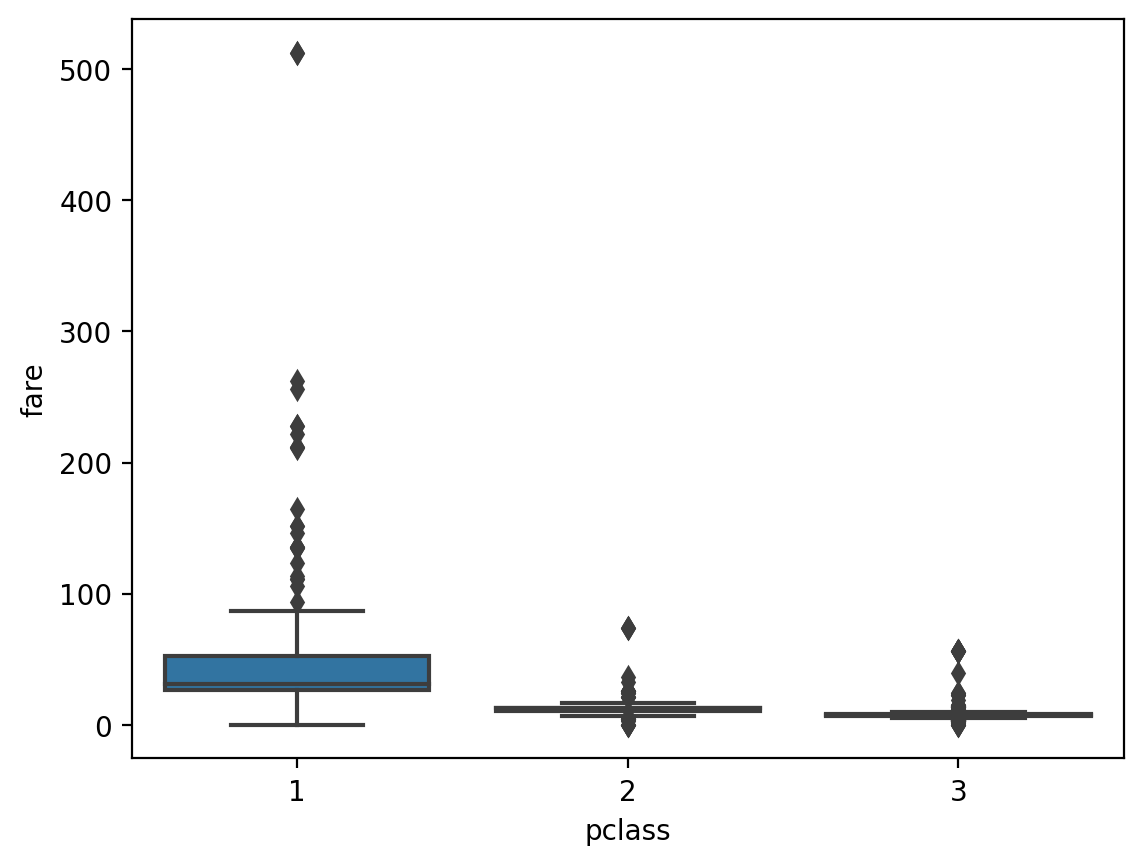

In [245]:
sns.boxplot(df_tr,x = 'pclass', y ='fare')

### Drop columns

In [246]:
df_tr.drop(columns = ['age_mean', 'passengerid','name','title','ticket','cabin'],inplace = True)
df_te.drop(columns = ['age_mean','passengerid','name','title','ticket','cabin'],inplace = True)

## Scaling
- fare에 이상치가 많음 -> robuster scaling 선택

In [247]:
 df_tr[['age','fare']]

,age,fare
0,32.0,12.875000
1,22.0,7.750000
2,52.0,31.166667
3,27.0,7.795800
4,44.0,13.000000
...,...,...
911,32.0,3.218750
912,18.0,8.662500
913,19.0,10.500000
914,22.0,7.733300


In [253]:
cols_scaling = ['age','fare']
scal_tr = df_tr[cols_scaling]
scal_te = df_te[cols_scaling]

In [263]:
from sklearn.preprocessing import RobustScaler

rbs = RobustScaler()
train_scaled = pd.DataFrame(rbs.fit_transform(scal_tr),columns = cols_scaling)
test_scaled = pd.DataFrame(rbs.transform(scal_te),columns = cols_scaling)

train_scaled

,age,fare
0,0.142857,0.250900
1,-0.571429,-0.054349
2,1.571429,1.340365
3,-0.214286,-0.051621
4,1.000000,0.258345
...,...,...
911,0.142857,-0.324234
912,-0.857143,0.000000
913,-0.785714,0.109443
914,-0.571429,-0.055344


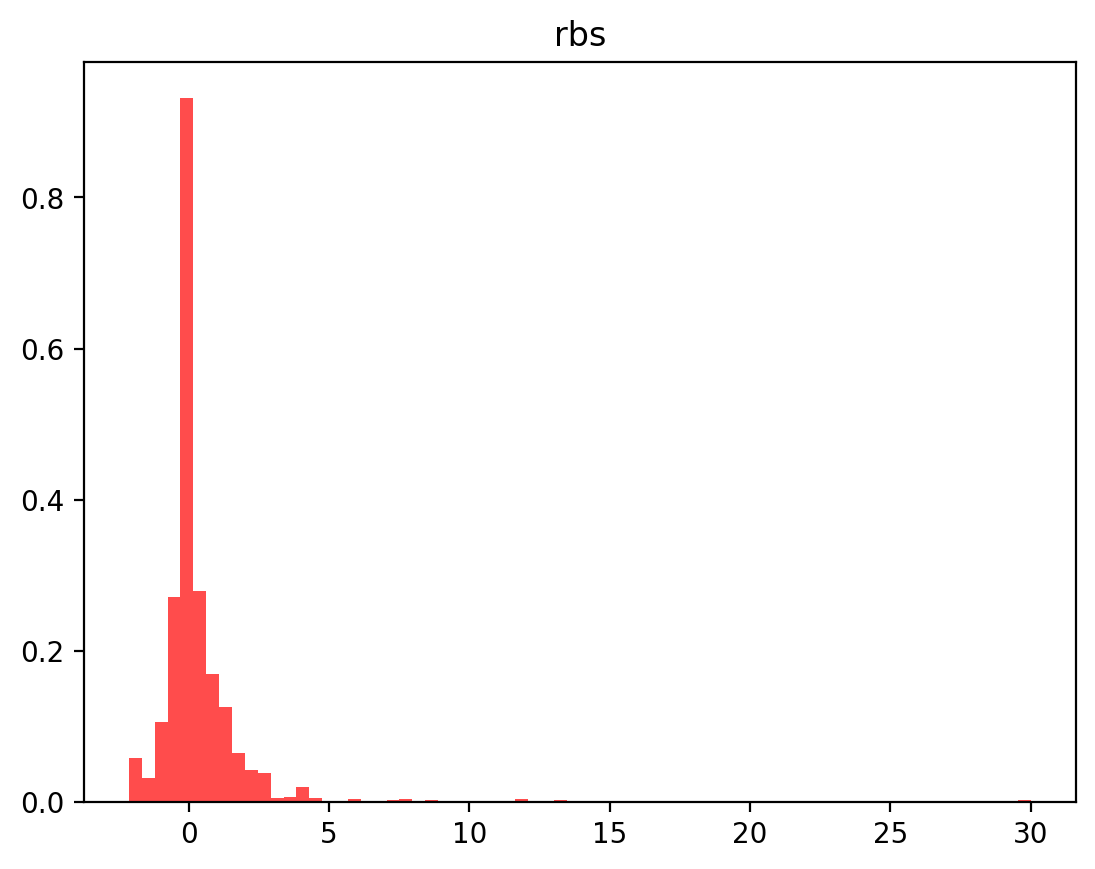

In [266]:
train_scaled_ss = rbs.fit_transform(scal_tr).reshape(1832,1)

plt.hist(train_scaled_ss, bins=70, color= 'red', alpha = 0.7, density = True)
plt.title('rbs')
plt.show()

## Encoding

In [107]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [267]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)

cols_encoding = ["gender",'family','pclass','embarked']
tmp_tr = df_tr[cols_encoding]
tmp_te = df_te[cols_encoding]

for col in tmp_tr.columns:
  train_enco = encoder.fit_transform(tmp_tr.astype('category'))
  test_enco = encoder.transform(tmp_te.astype('category'))

print(f'{train_enco.shape} / {test_enco.shape}')
train_enco.head()

(916, 13) / (393, 13)


,gender_0.0,gender_1.0,family_0.0,family_2.0,family_1.0,family_4.0,family_3.0,pclass_2.0,pclass_3.0,pclass_1.0,embarked_S,embarked_Q,embarked_C
0,1,0,1,0,0,0,0,1,0,0,1,0,0
1,0,1,1,0,0,0,0,0,1,0,0,1,0
2,0,1,0,1,0,0,0,0,0,1,1,0,0
3,1,0,1,0,0,0,0,0,1,0,1,0,0
4,1,0,0,0,1,0,0,1,0,0,1,0,0


### Drop Encoded columns

In [111]:
# train_enco.drop(columns = ['family_1.0','family_2.0', 'family_3.0', 'pclass_2.0'],inplace = True)
# test_enco.drop(columns = ['family_1.0','family_2.0', 'family_3.0', 'pclass_2.0'],inplace = True)

# Prediction

In [268]:
train = pd.concat([train_enco, train_scaled, df_tr['survived']], axis =1)
test = pd.concat([test_enco, test_scaled], axis =1)

In [269]:
X = train.drop(['survived'], axis = 1)
y = train['survived']

In [287]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 915
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gender_0.0  916 non-null    int64  
 1   gender_1.0  916 non-null    int64  
 2   family_0.0  916 non-null    int64  
 3   family_2.0  916 non-null    int64  
 4   family_1.0  916 non-null    int64  
 5   family_4.0  916 non-null    int64  
 6   family_3.0  916 non-null    int64  
 7   pclass_2.0  916 non-null    int64  
 8   pclass_3.0  916 non-null    int64  
 9   pclass_1.0  916 non-null    int64  
 10  embarked_S  916 non-null    int64  
 11  embarked_Q  916 non-null    int64  
 12  embarked_C  916 non-null    int64  
 13  age         916 non-null    float64
 14  fare        916 non-null    float64
dtypes: float64(2), int64(13)
memory usage: 114.5 KB


### Confusion Matrix

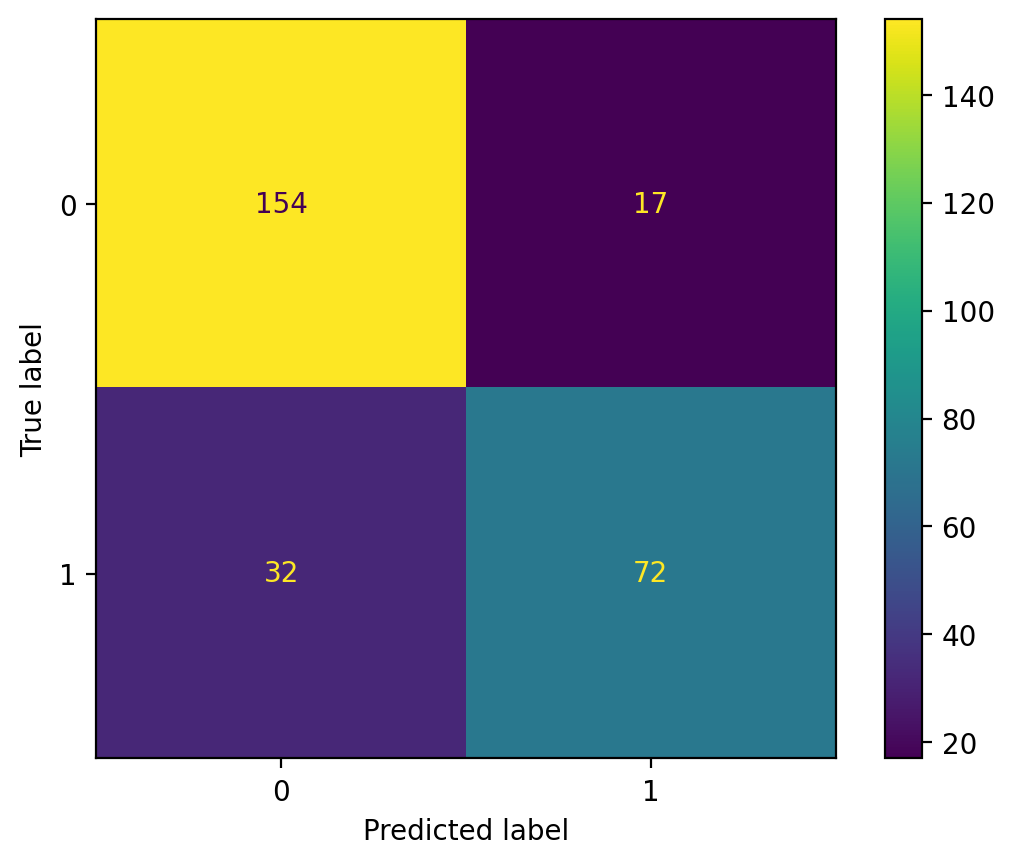

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict # 교차검증
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = pin.random_state)
rf = RandomForestClassifier()
cat = CatBoostClassifier(verbose = False)
y_test_pred = rf.fit(X_train, y_train).predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()


In [292]:
true_df = y_test.reset_index().rename(columns = {'survived' : 'true'})

pred_df = pd.Series(y_test_pred)
pred_df.name = 'pred'

true_pred = pd.concat([true_df,pred_df], axis = 1)

tp = true_pred[true_pred['true'] == 1][true_pred.pred == 0] 

In [293]:
ori_train.reset_index().merge(tp) # 예측 실패한 승객(살았는데 죽었다고 예측)

,index,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,title,true,pred
0,30,30,1,3,"Nakid, Mr. Sahid",male,20.0,1,1,2653,15.7417,NaN,C,Mr.,1,0
1,37,37,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S,Master.,1,0
2,62,62,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,Mr.,1,0
3,71,71,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S,Mr.,1,0
4,118,118,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S,Mr.,1,0
5,119,119,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,Mr.,1,0
6,122,122,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,Major.,1,0
7,145,145,1,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S,Master.,1,0
8,187,187,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,Mr.,1,0
9,190,190,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mr.,1,0


## Model Selection

In [288]:
#모델 실행 후 결과 저장
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import roc_auc_score



def models_results_df(X, y, test, SEED):
    results = []

    cat = CatBoostClassifier(verbose = False)
    lgb = LGBMClassifier()
    rf = RandomForestClassifier()
    xgb = XGBClassifier()

    clf_dict = {'CatBoost' : cat,
                  'LGBM' : lgb,
                  'RandomForest': rf,
                  'XGB' : xgb}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = SEED)

    for name, clf in clf_dict.items():
        model = clf.fit(X_train, y_train)
        model_name = name
        score_tr = clf.score(X_train,y_train)
        score_te = clf.score(X_test,y_test)
        top_features = pd.Series(model.feature_importances_, index = X_train.columns)
        pred = model.predict_proba(test)[:,1]


        results.append({'model': model_name,
                'score_tr': score_tr,
                'score_te': score_te,
                'pred': pred,
                'len_features': X_train.shape[1],
                'feaute_importances': top_features.sort_values(ascending=False)[:20].index
        })

        df = pd.DataFrame(results).sort_values(by=['score_te'], ascending=False)

    return df

In [289]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import roc_auc_score

cat = CatBoostClassifier(verbose = False)
lgb = LGBMClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

def models_scores_df(X, y, test, SEED):
    results = []


    clf_dict = {'CatBoost' : cat,
                  'LGBM' : lgb,
                  'RandomForest': rf,
                  'XGB' : xgb}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = SEED)

    for name, clf in clf_dict.items():
        model = clf.fit(X_train, y_train)
        model_name = name
        score_te = clf.score(X_test,y_test)
        y_pred = model.predict(X_test)
        AUC = roc_auc_score(y_test,y_pred)
        top_features = pd.Series(model.feature_importances_, index = X_train.columns)


        results.append({
            'model': model_name,
            'score_te': score_te,
            'AUC': AUC,
            'feaute_importances': top_features.sort_values(ascending=False)[:20].index
        })

        df = pd.DataFrame(results).sort_values(by=['score_te'], ascending=False)

    return df

In [290]:
results = models_scores_df(X, y, test, pin.random_state)

In [291]:
results

,model,score_te,AUC,feaute_importances
0,CatBoost,0.843636,0.817758,"Index(['gender_0.0', 'gender_1.0', 'age', 'far..."
1,LGBM,0.829091,0.800410,"Index(['fare', 'age', 'gender_0.0', 'embarked_..."
3,XGB,0.825455,0.801254,"Index(['gender_0.0', 'family_4.0', 'pclass_3.0..."
2,RandomForest,0.818182,0.791639,"Index(['gender_0.0', 'gender_1.0', 'age', 'far..."


## HPO

In [294]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.4 MB/s eta 0:00:00


In [299]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

In [308]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
        self.cv = KFold(n_splits=num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",1,5),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        model = CatBoostClassifier(random_state=self.seed,**hp, verbose = False)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

In [309]:
sampler = TPESampler(seed=pin.random_state) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)
objective = Objective(X_train, y_train, pin.random_state)
study.optimize(objective,n_trials=50)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

Best Score: 0.9135979889391654
Best hp {'max_depth': 1, 'n_estimators': 410, 'learning_rate': 0.01971711301464138}


In [311]:
model = CatBoostClassifier(random_state=pin.random_state, **study.best_params, verbose = False)
model.fit(X_train,y_train)

pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,pred)

0.8656376518218624

# Submission

In [316]:
pred = model.predict_proba(test)[:,1]
pred

array([0.76456126, 0.83006253, 0.76221773, 0.07888425, 0.92658987,
       0.83006253, 0.08306976, 0.08367062, 0.74318851, 0.08730905,
       0.08367062, 0.03029766, 0.73425764, 0.75053131, 0.12439457,
       0.25401289, 0.19131146, 0.12321997, 0.07072521, 0.08367062,
       0.08306976, 0.1201973 , 0.08367062, 0.12439457, 0.07072521,
       0.08306976, 0.26579093, 0.76078974, 0.25798155, 0.15151244,
       0.75040261, 0.75667819, 0.10075746, 0.25798155, 0.25401289,
       0.08256013, 0.85934203, 0.12214267, 0.26853296, 0.06936791,
       0.08068496, 0.88217173, 0.08467077, 0.89090293, 0.12214267,
       0.12214267, 0.25401289, 0.14734434, 0.08208683, 0.07888425,
       0.37414384, 0.04145394, 0.92427342, 0.08306976, 0.7549683 ,
       0.76049412, 0.19455597, 0.08306976, 0.12214267, 0.46763311,
       0.92280203, 0.73425764, 0.76456126, 0.02394048, 0.1022771 ,
       0.1201973 , 0.3141299 , 0.83006253, 0.08306976, 0.95509619,
       0.08041167, 0.81879521, 0.75667819, 0.82747   , 0.07296

In [317]:
submission = pd.read_csv(pin.default_submission_csv)
submission['survived'] = pred
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.764561
1,917,0.830063
2,918,0.762218
3,919,0.078884
4,920,0.926590
5,921,0.830063
6,922,0.083070
7,923,0.083671
8,924,0.743189
9,925,0.087309


In [319]:
pin.submission_csv = pin.default_path +'result/'+ 'Cat,Hpo'+'.csv'
submission.to_csv(pin.submission_csv, header=True, index=False)